In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

%load_ext autoreload
%autoreload 2

os.chdir('/content/drive/MyDrive/AI+X_middle_01/')

#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [3]:
!pip install catboost

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import random
from tqdm import tqdm

import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import *

* 함수 생성

In [5]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [6]:
data = pd.read_csv('data/data01_train.csv')
data.drop('subject', axis = 1, inplace = True)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


#### 2) 기본 정보 조회

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


In [8]:
data.shape

(5881, 562)

In [9]:
data['Activity'].value_counts()

,count
Activity,
LAYING,1115
STANDING,1087
SITTING,1032
WALKING,998
WALKING_UPSTAIRS,858
WALKING_DOWNSTAIRS,791


## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [10]:
X = data.drop('Activity', axis = 1)
y = data['Activity']

In [11]:
X.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.032207,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.246705,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,0.388765,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,0.050888,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.013902,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758


In [12]:
y.head()

,Activity
0,STANDING
1,LAYING
2,STANDING
3,WALKING
4,WALKING_DOWNSTAIRS


In [13]:
y = y.map({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2, 'LAYING':3, 'STANDING':4, 'SITTING':5})
y.head()

,Activity
0,4
1,3
2,4
3,0
4,2


### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [14]:
sc = MinMaxScaler()
X = pd.DataFrame(sc.fit_transform(X), columns = X.columns)
X.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.526878,0.401033,0.448319,0.005507,0.019335,0.016125,0.005500,0.018720,0.017175,0.035126,...,0.488133,0.249657,0.093564,0.472577,0.477891,0.654361,0.537449,0.201725,0.900647,0.578396
1,0.511749,0.396653,0.450918,0.005224,0.002718,0.006117,0.004906,0.002821,0.006221,0.031332,...,0.375973,0.376595,0.156521,0.462253,0.694229,0.117569,0.887502,0.680309,0.156150,0.420272
2,0.520362,0.397878,0.445641,0.001140,0.009789,0.002830,0.001033,0.008760,0.002492,0.028708,...,0.708258,0.225505,0.087117,0.494210,0.237489,0.054098,0.511768,0.084172,0.813468,0.478444
3,0.527733,0.385400,0.424823,0.384137,0.518471,0.330830,0.363222,0.515313,0.326042,0.504144,...,0.531583,0.495352,0.301955,0.365002,0.806402,0.874258,0.464438,0.153833,0.870783,0.551238
4,0.597564,0.426728,0.545615,0.544245,0.466164,0.305633,0.494765,0.452314,0.326814,0.792066,...,0.497705,0.417223,0.223002,0.471641,0.077366,0.012683,0.056187,0.149176,0.855762,0.564555


In [15]:
# LGBM을 위한 JSON 데이터 처리

import re

X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle=False)

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다.
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 : RandomForestClassifier


In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

pred = rf_model.predict(X_val)

# 평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

# 데이터프레임에 추가
eval_df_rf = pd.DataFrame({'model':['RandomForestClassifier'], 'accuracy':[accuracy_score(y_val, pred)], 'f1_score':[f1_score(y_val, pred, average='macro')]})
eval_df_rf

accuracy : 0.9830076465590484
[[187   1   1   0   0   0]
 [  0 175   1   0   0   0]
 [  0   0 154   0   0   0]
 [  0   0   0 233   0   0]
 [  0   0   0   0 214   6]
 [  0   1   0   0  10 194]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       189
           1       0.99      0.99      0.99       176
           2       0.99      1.00      0.99       154
           3       1.00      1.00      1.00       233
           4       0.96      0.97      0.96       220
           5       0.97      0.95      0.96       205

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



,model,accuracy,f1_score
0,RandomForestClassifier,0.983008,0.98362


,feature_name,feature_importance
0,tGravityAcc_mean___X,0.033927
1,tGravityAcc_max___X,0.030526
2,angle_X_gravityMean_,0.029902
3,tGravityAcc_mean___Y,0.025950
4,tGravityAcc_min___Y,0.024612
...,...,...
195,fBodyGyro_iqr___X,0.000636
196,fBodyGyro_bandsEnergy___1_8_2,0.000635
197,fBodyAccJerk_bandsEnergy___25_48_2,0.000621
198,tBodyGyro_arCoeff___Y_1,0.000620


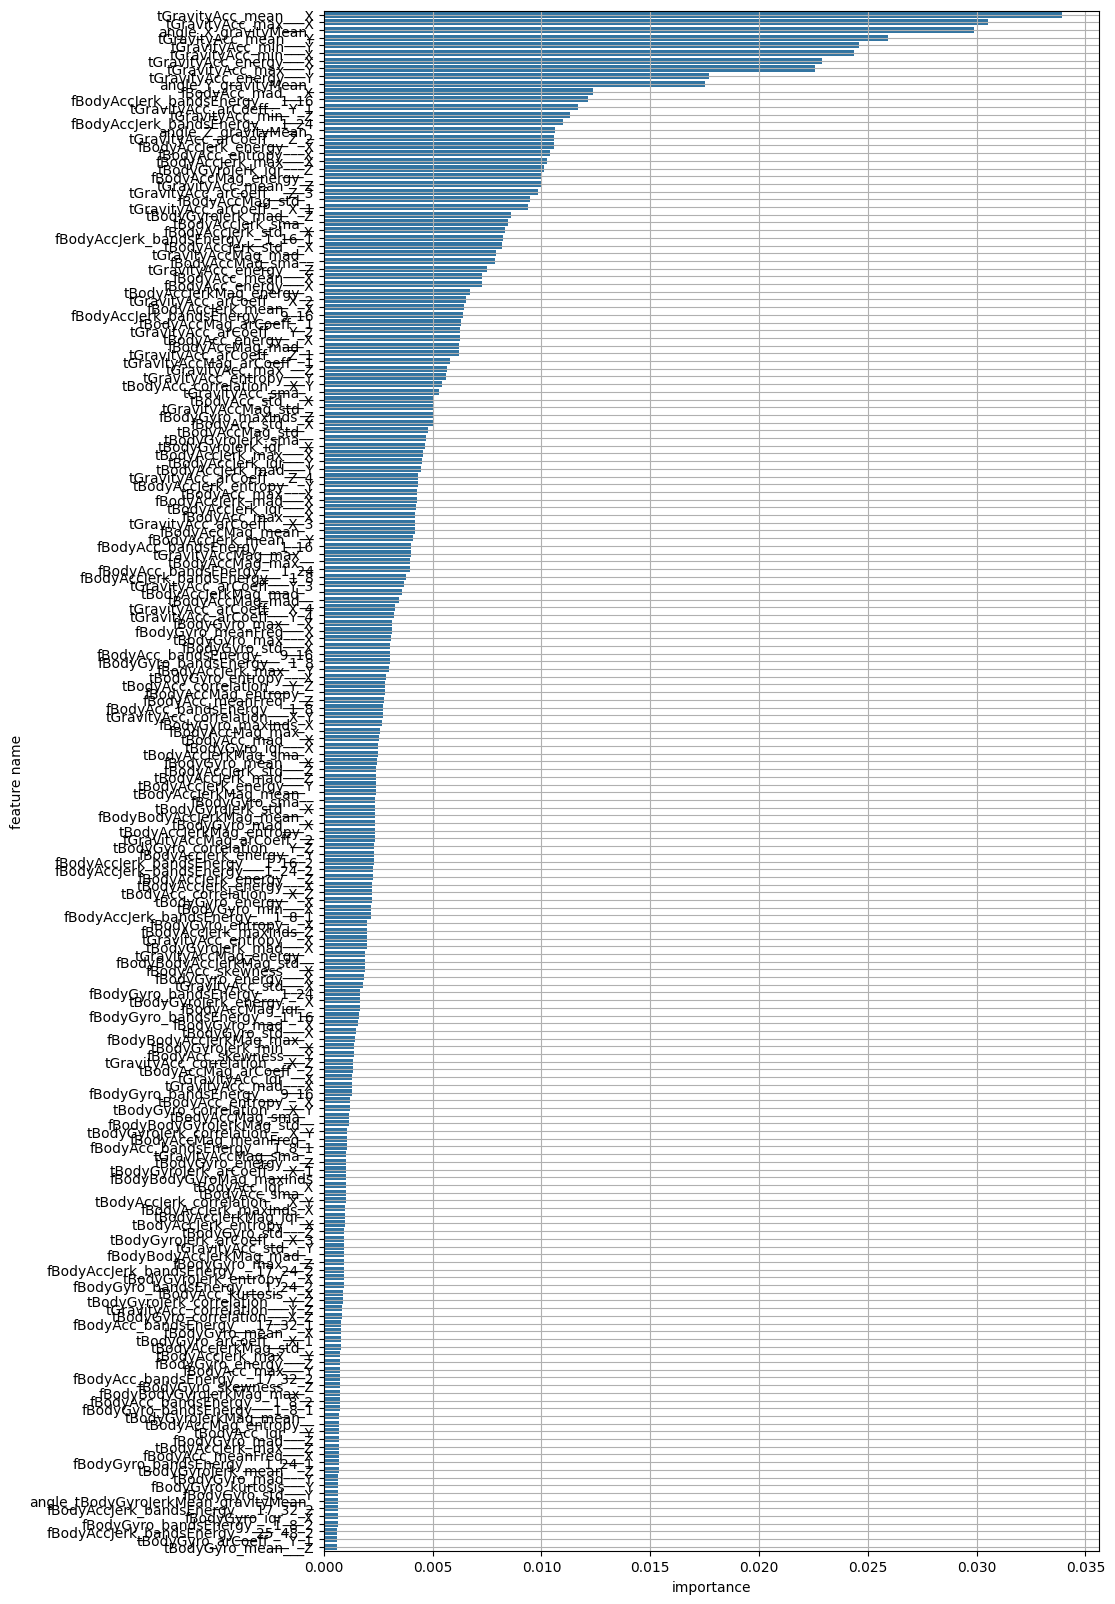

In [18]:
# 상위 200개 feature 확인
r0 = plot_feature_importance(rf_model.feature_importances_, list(X_train), False, 200)
r0

In [19]:
X_train_200 = X_train[r0['feature_name']]
X_val_200 = X_val[r0['feature_name']]

In [20]:
rf_200_model = RandomForestClassifier(random_state=42)
rf_200_model.fit(X_train_200, y_train)

pred = rf_200_model.predict(X_val_200)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

accuracy : 0.9830076465590484
[[186   2   1   0   0   0]
 [  0 176   0   0   0   0]
 [  1   0 153   0   0   0]
 [  0   0   0 233   0   0]
 [  0   0   0   0 215   5]
 [  0   0   0   0  11 194]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       189
           1       0.99      1.00      0.99       176
           2       0.99      0.99      0.99       154
           3       1.00      1.00      1.00       233
           4       0.95      0.98      0.96       220
           5       0.97      0.95      0.96       205

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



### (2) 알고리즘2 : XGBClassifier

In [21]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

pred = xgb_model.predict(X_val)

# 평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

# 데이터프레임에 추가
eval_df_xgb = pd.DataFrame({'model':['XGBClassifier'], 'accuracy':[accuracy_score(y_val, pred)], 'f1_score':[f1_score(y_val, pred, average='macro')]})
eval_df_xgb

accuracy : 0.9923534409515717
[[189   0   0   0   0   0]
 [  0 176   0   0   0   0]
 [  0   0 154   0   0   0]
 [  0   0   0 233   0   0]
 [  0   0   0   0 217   3]
 [  0   1   0   0   5 199]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       0.99      1.00      1.00       176
           2       1.00      1.00      1.00       154
           3       1.00      1.00      1.00       233
           4       0.98      0.99      0.98       220
           5       0.99      0.97      0.98       205

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



,model,accuracy,f1_score
0,XGBClassifier,0.992353,0.992826


,feature_name,feature_importance
0,fBodyAccMag_mad__,0.071949
1,fBodyAcc_bandsEnergy___1_8_2,0.067658
2,angle_Y_gravityMean_,0.058169
3,fBodyAcc_skewness___X,0.050429
4,tGravityAcc_mean___X,0.044823
...,...,...
195,fBodyGyro_bandsEnergy___9_16_1,0.000408
196,tBodyAcc_correlation___Y_Z,0.000408
197,tBodyGyro_arCoeff___X_4,0.000401
198,tBodyGyro_arCoeff___Y_3,0.000400


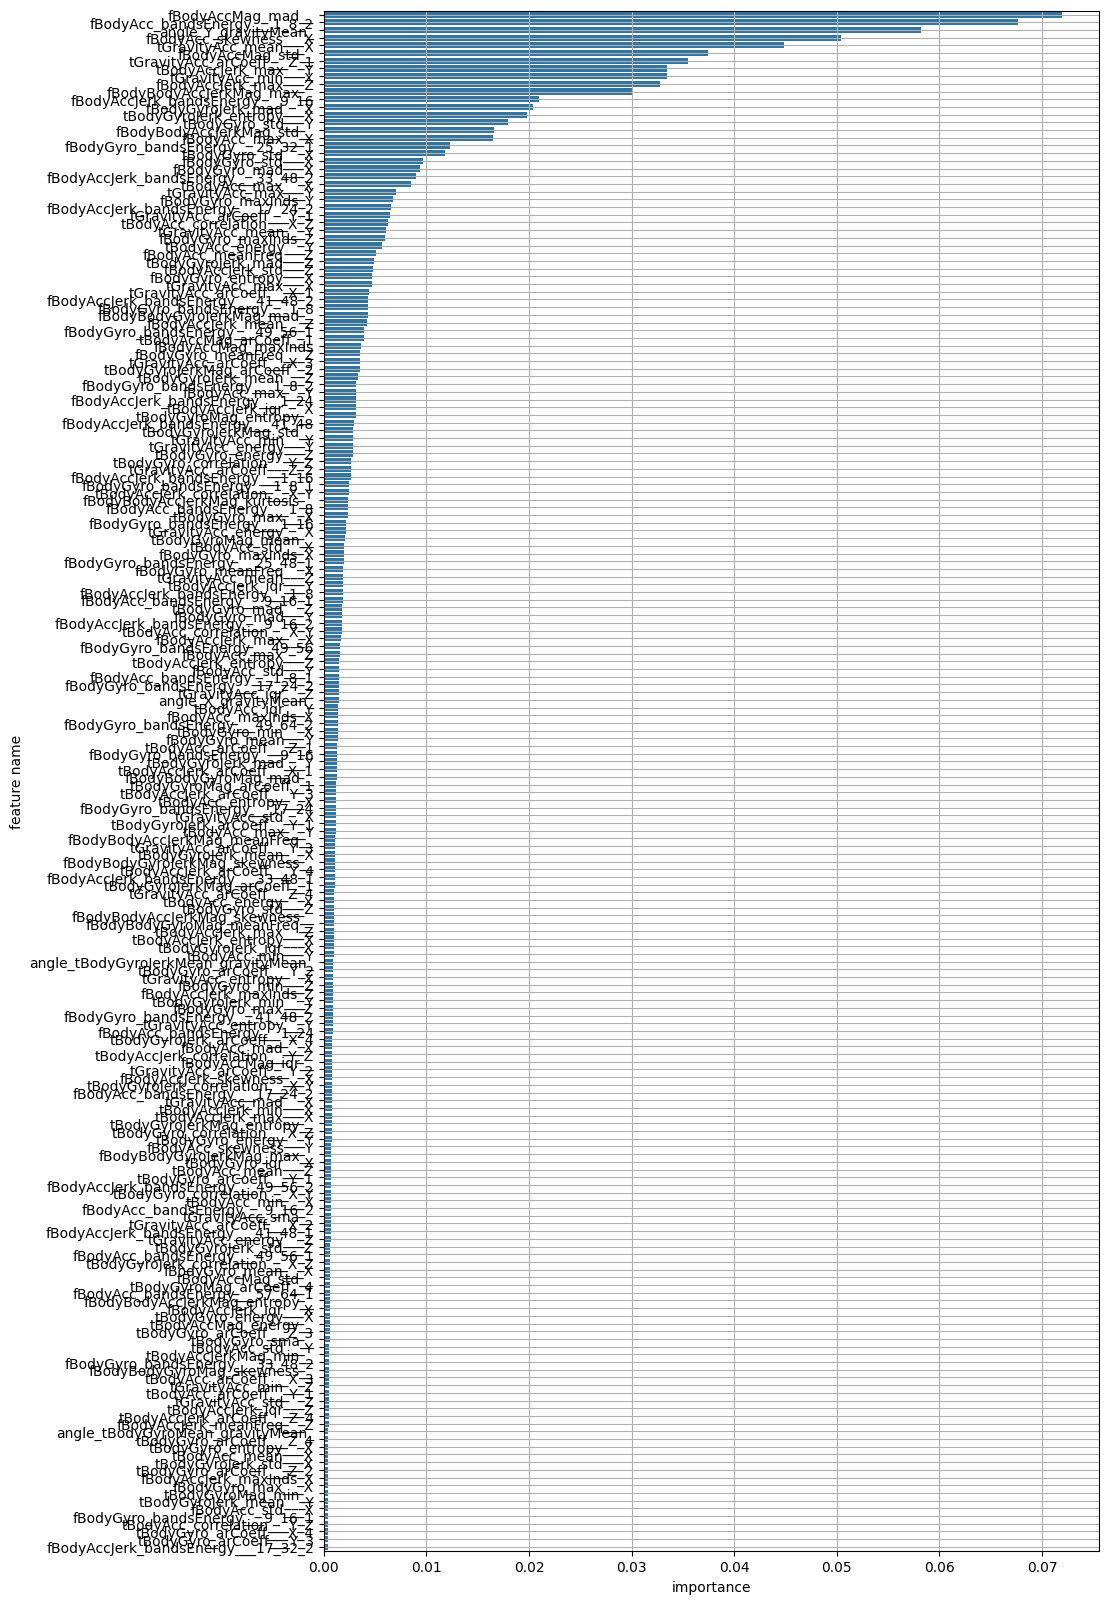

In [22]:
# 상위 200개 feature 확인
r0 = plot_feature_importance(xgb_model.feature_importances_, list(X_train), False, 200)
r0

In [23]:
X_train_200 = X_train[r0['feature_name']]
X_val_200 = X_val[r0['feature_name']]
X_train_200.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4704 entries, 0 to 4703
Columns: 200 entries, fBodyAccMag_mad__ to fBodyAccJerk_bandsEnergy___17_32_2
dtypes: float64(200)
memory usage: 7.2 MB


In [24]:
xgb_200_model = XGBClassifier(random_state=42)
xgb_200_model.fit(X_train_200, y_train)

pred = xgb_200_model.predict(X_val_200)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

accuracy : 0.994052676295667
[[189   0   0   0   0   0]
 [  0 176   0   0   0   0]
 [  0   0 154   0   0   0]
 [  0   0   0 233   0   0]
 [  0   0   0   0 217   3]
 [  0   1   0   0   3 201]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       189
           1       0.99      1.00      1.00       176
           2       1.00      1.00      1.00       154
           3       1.00      1.00      1.00       233
           4       0.99      0.99      0.99       220
           5       0.99      0.98      0.98       205

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



### (3) 알고리즘3 : LGBMClassifier

In [25]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train, y_train)

pred = lgbm_model.predict(X_val)

# 평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

# 데이터프레임에 추가
eval_df_lgbm = pd.DataFrame({'model':['LGBMClassifier'], 'accuracy':[accuracy_score(y_val, pred)], 'f1_score':[f1_score(y_val, pred, average='macro')]})
eval_df_lgbm

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 140131
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 561
[LightGBM] [Info] Start training from score -1.760370
[LightGBM] [Info] Start training from score -1.931139
[LightGBM] [Info] Start training from score -1.999399
[LightGBM] [Info] Start training from score -1.673976
[LightGBM] [Info] Start training from score -1.691130
[LightGBM] [Info] Start training from score -1.738364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

,model,accuracy,f1_score
0,LGBMClassifier,0.994902,0.995287


,feature_name,feature_importance
0,tGravityAcc_energy___Y,419
1,tGravityAcc_min___Y,404
2,tBodyAcc_correlation___X_Y,273
3,tBodyGyro_correlation___Y_Z,260
4,angle_X_gravityMean_,226
...,...,...
195,fBodyBodyGyroMag_max__,21
196,fBodyAccJerk_skewness___X,21
197,fBodyGyro_bandsEnergy___1_8_1,21
198,tBodyAccJerk_iqr___X,21


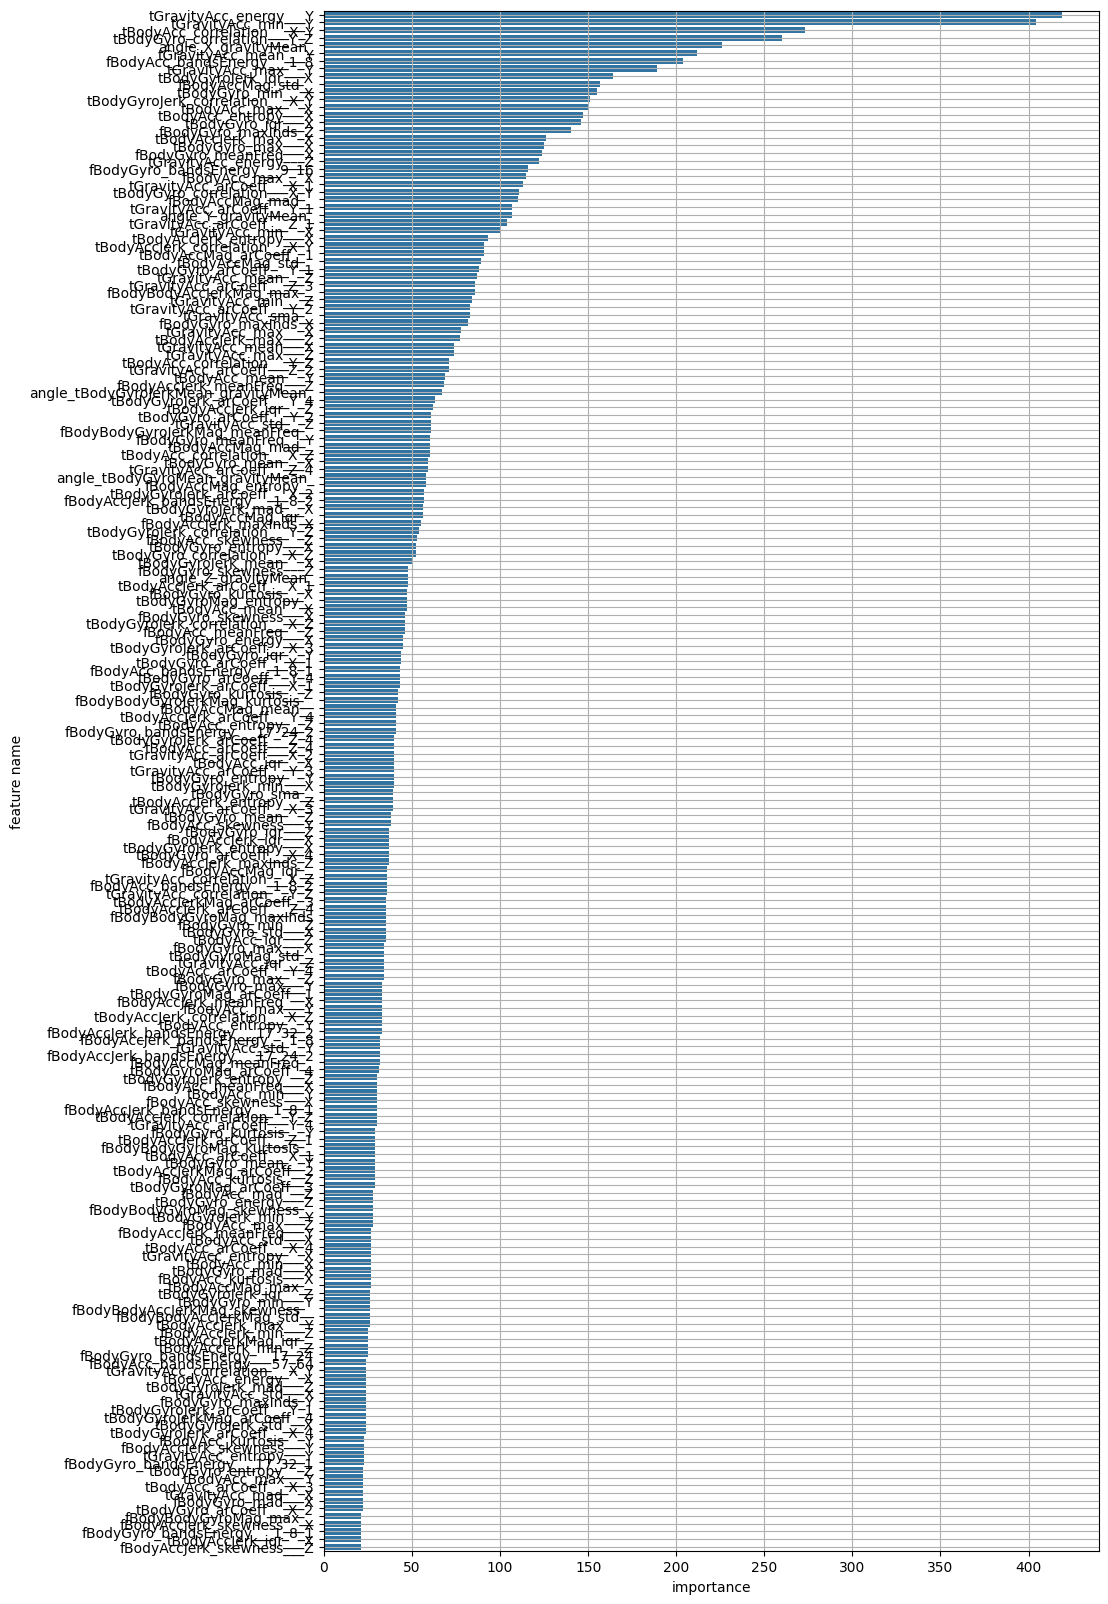

In [26]:
# 상위 200개 feature 확인
r0 = plot_feature_importance(lgbm_model.feature_importances_, list(X_train), False, 200)
r0

In [27]:
X_train_200 = X_train[r0['feature_name']]
X_val_200 = X_val[r0['feature_name']]
X_train_200.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4704 entries, 0 to 4703
Columns: 200 entries, tGravityAcc_energy___Y to fBodyAccJerk_skewness___Z
dtypes: float64(200)
memory usage: 7.2 MB


In [28]:
lgbm_200_model = LGBMClassifier(random_state=42)
lgbm_200_model.fit(X_train_200, y_train)

pred = lgbm_200_model.predict(X_val_200)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49645
[LightGBM] [Info] Number of data points in the train set: 4704, number of used features: 200
[LightGBM] [Info] Start training from score -1.760370
[LightGBM] [Info] Start training from score -1.931139
[LightGBM] [Info] Start training from score -1.999399
[LightGBM] [Info] Start training from score -1.673976
[LightGBM] [Info] Start training from score -1.691130
[LightGBM] [Info] Start training from score -1.738364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

### (4) 알고리즘4 : CatBoostClassifier

In [29]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(random_state=42,
                        iterations=300,
                        depth=5,
                        learning_rate=0.1,
                        verbose=False)
cb_model.fit(X_train, y_train)

pred = cb_model.predict(X_val)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

# 데이터프레임에 추가
eval_df_cb = pd.DataFrame({'model':['CatBoostClassifier'], 'accuracy':[accuracy_score(y_val, pred)], 'f1_score':[f1_score(y_val, pred, average='macro')]})
eval_df_cb

accuracy : 0.983857264231096
[[188   1   0   0   0   0]
 [  1 175   0   0   0   0]
 [  0   1 153   0   0   0]
 [  0   0   0 233   0   0]
 [  0   0   0   0 215   5]
 [  0   1   0   0  10 194]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       189
           1       0.98      0.99      0.99       176
           2       1.00      0.99      1.00       154
           3       1.00      1.00      1.00       233
           4       0.96      0.98      0.97       220
           5       0.97      0.95      0.96       205

    accuracy                           0.98      1177
   macro avg       0.98      0.98      0.98      1177
weighted avg       0.98      0.98      0.98      1177



,model,accuracy,f1_score
0,CatBoostClassifier,0.983857,0.984473


,feature_name,feature_importance
0,tGravityAcc_mean___X,6.598635
1,tGravityAcc_mean___Y,5.342972
2,fBodyBodyAccJerkMag_mad__,4.964650
3,tGravityAcc_min___X,4.241392
4,tGravityAcc_max___X,3.648026
...,...,...
195,fBodyAcc_bandsEnergy___17_24_1,0.050729
196,fBodyGyro_entropy___X,0.050633
197,fBodyAcc_bandsEnergy___57_64,0.049976
198,tBodyGyroJerk_entropy___X,0.049439


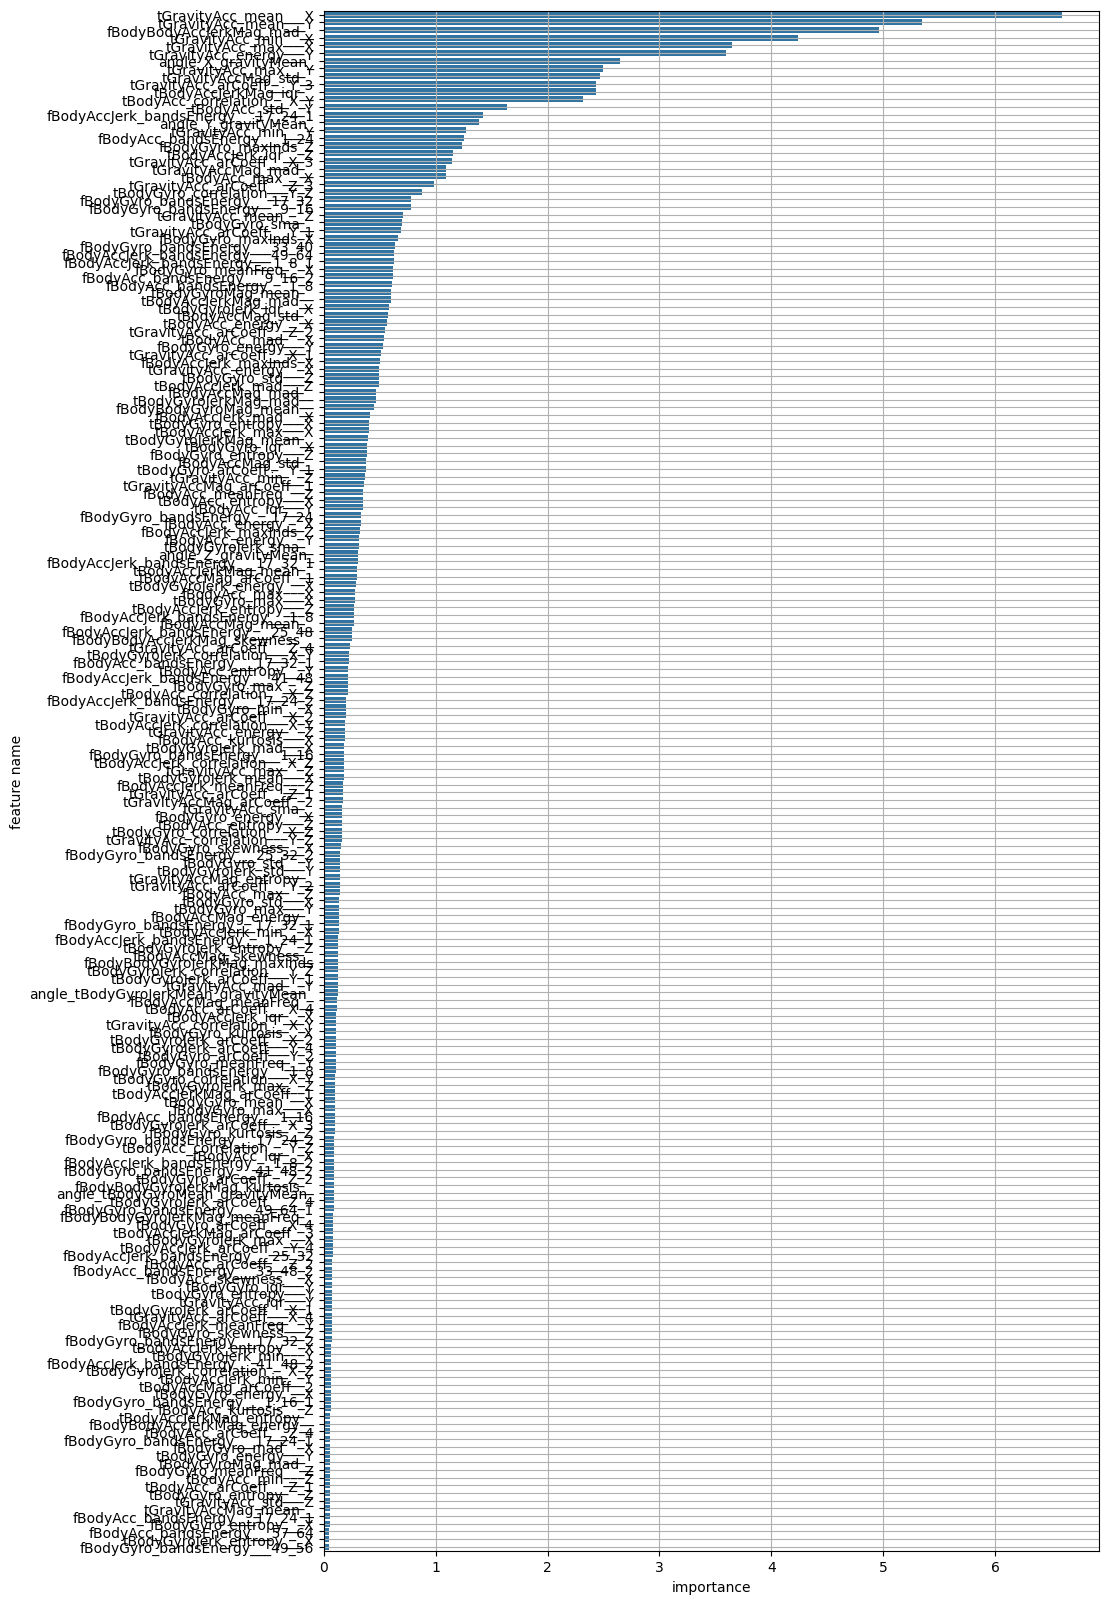

In [30]:
# 상위 200개 feature 확인
r0 = plot_feature_importance(cb_model.feature_importances_, list(X_train), False, 200)
r0

In [31]:
X_train_200 = X_train[r0['feature_name']]
X_val_200 = X_val[r0['feature_name']]
X_train_200.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4704 entries, 0 to 4703
Columns: 200 entries, tGravityAcc_mean___X to fBodyGyro_bandsEnergy___49_56
dtypes: float64(200)
memory usage: 7.2 MB


In [32]:
cb_200_model = CatBoostClassifier(random_state=42,
                                  iterations=300,
                                  depth=5,
                                  learning_rate=0.1,
                                  verbose=False)
cb_200_model.fit(X_train_200, y_train)

pred = cb_200_model.predict(X_val_200)

#평가
print('accuracy :',accuracy_score(y_val, pred))
print('='*60)
print(confusion_matrix(y_val, pred))
print('='*60)
print(classification_report(y_val, pred))

accuracy : 0.9864061172472387
[[187   2   0   0   0   0]
 [  0 176   0   0   0   0]
 [  0   0 154   0   0   0]
 [  0   0   0 233   0   0]
 [  0   0   0   0 216   4]
 [  0   1   0   0   9 195]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       189
           1       0.98      1.00      0.99       176
           2       1.00      1.00      1.00       154
           3       1.00      1.00      1.00       233
           4       0.96      0.98      0.97       220
           5       0.98      0.95      0.97       205

    accuracy                           0.99      1177
   macro avg       0.99      0.99      0.99      1177
weighted avg       0.99      0.99      0.99      1177



<hr />

## 모델 성능 비교

In [33]:
eval_df = pd.concat([eval_df_rf, eval_df_xgb, eval_df_lgbm, eval_df_cb], axis = 0)
eval_df

,model,accuracy,f1_score
0,RandomForestClassifier,0.983008,0.983620
0,XGBClassifier,0.992353,0.992826
0,LGBMClassifier,0.994902,0.995287
0,CatBoostClassifier,0.983857,0.984473


* LightBGM 모델의 성능 우수

<hr />

## test셋으로 평가하기

In [34]:
new_data = pd.read_csv('data/data01_test.csv')
new_data.drop('subject', axis = 1, inplace = True)
new_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [35]:
X = new_data.drop('Activity', axis = 1)
y = new_data['Activity']

In [36]:
y = y.map({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2, 'LAYING':3, 'STANDING':4, 'SITTING':5})
y.head()

,Activity
0,5
1,4
2,0
3,5
4,4


In [37]:
X = pd.DataFrame(sc.fit_transform(X), columns = X.columns)
X

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.787233,0.719350,0.313492,0.003805,0.011351,0.018992,0.003745,0.014164,0.023396,0.005578,...,0.674778,0.250887,0.076553,0.479277,0.546207,0.537519,0.130624,0.163769,0.684186,0.408612
1,0.782980,0.714860,0.311696,0.001631,0.040504,0.014345,0.001293,0.042806,0.015746,0.005020,...,0.448081,0.405152,0.201865,0.476977,0.421248,0.624612,0.439708,0.086308,0.826273,0.467341
2,0.800383,0.705344,0.344023,0.529889,0.663505,0.394559,0.515481,0.641899,0.427936,0.545235,...,0.789220,0.813307,0.735386,0.299658,0.585939,0.789898,0.144080,0.128112,0.887704,0.528462
3,0.782130,0.723391,0.322120,0.002284,0.008918,0.012502,0.002046,0.009186,0.013998,0.004124,...,0.718961,0.221571,0.081111,0.639618,0.539900,0.490146,0.647117,0.180028,0.618587,0.439942
4,0.779645,0.747950,0.352802,0.013818,0.166854,0.067596,0.010283,0.179973,0.080201,0.015799,...,0.217794,0.745136,0.640002,0.493953,0.557242,0.082653,0.330480,0.079306,0.778463,0.453332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,0.783768,0.724292,0.324180,0.003207,0.009553,0.013077,0.003027,0.011794,0.014173,0.005322,...,0.626776,0.211094,0.063847,0.460123,0.859299,0.651160,0.333513,0.071044,0.781228,0.561669
1467,0.781977,0.721353,0.321395,0.000581,0.004630,0.006523,0.000541,0.005302,0.007330,0.001854,...,0.765950,0.280622,0.144856,0.528474,0.488750,0.360856,0.884270,0.117634,0.845622,0.571364
1468,0.760279,0.740196,0.308614,0.502154,0.667505,0.690032,0.453783,0.722497,0.669957,0.654746,...,0.638348,0.403836,0.200707,0.660902,0.162862,0.905607,0.061046,0.179964,0.826886,0.632388
1469,0.696210,0.720310,0.313533,0.020631,0.025099,0.007343,0.018841,0.017887,0.006512,0.001375,...,0.429768,0.551498,0.302974,0.463414,0.619077,0.406437,0.700874,0.895406,0.364575,0.247920


In [38]:
# LGBM을 위한 JSON 데이터 처리

import re

X.columns = [re.sub(r'[^\w]', '_', col) for col in X.columns]

In [39]:
pred = lgbm_model.predict(X)
print('accuracy :',accuracy_score(y, pred))
print('='*60)

accuracy : 0.9782460910944936
